In [1]:
import json
import numpy as np 
file_path = "/Users/shrutijha/Desktop/data" 

In [2]:
file_path1 = "/Users/shrutijha/Desktop/NLP/"

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score, accuracy_score
import json

device = 'cpu'

def load_data(file):
    with open(file, 'r') as file:
        data = json.load(file)
    return data

def load_data_x(file):
    with open(file, 'r') as file:
        data = json.load(file)
    sentences, labels = [], []
    for _, value in data.items():
        sentences.append(value['text'].split())
        labels.append(value['labels'])
    return sentences, labels

train_data = load_data('./NER_TRAIN.json')
val_data = load_data('./NER_VAL.json')
test_data = load_data('./NER_TEST.json')

train_sentences, train_labels = load_data_x('./NER_TRAIN.json')
val_sentences, val_labels = load_data_x('./NER_VAL.json')
test_sentences, test_labels = load_data_x('./NER_TEST.json')

In [12]:
tag_to_ix = {}
rank = 0
for i in train_labels+ test_labels + val_labels:
    for j in i:
        if j not in tag_to_ix:
            tag_to_ix[j] = rank
            rank += 1
print(tag_to_ix)

{'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}


In [13]:
class ReviewDataset(Dataset):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    def __init__(self, data, embedding_model, embedding_type='word2vec'):
        self.data = [(item['text'].split(), item['labels']) for item in data.values()]
        self.embedding_model = embedding_model
        self.embedding_type = embedding_type

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, labels = self.data[idx]
        if self.embedding_type == 'word2vec' or self.embedding_type == 'glove':
            vectors = [self.embedding_model[word] if word in self.embedding_model else np.zeros(self.embedding_model.vector_size) for word in words]
        elif self.embedding_type == 'fasttext':
            vectors = [self.embedding_model.wv[word] if word in self.embedding_model.wv else np.zeros(self.embedding_model.vector_size) for word in words]
        else:
            raise ValueError("Unsupported embedding type specified.")

        label_indices = [self.label_to_index(label) for label in labels]
        return torch.tensor(vectors, dtype=torch.float), torch.tensor(label_indices, dtype=torch.long)

    @staticmethod
    def label_to_index(label):
        return ReviewDataset.label_mapping[label]

def collate_fn(batch):
    vectors, labels = zip(*batch)
    vectors_padded = pad_sequence(vectors, batch_first=True, padding_value=0.0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)
    return vectors_padded, labels_padded

class BaseModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='RNN'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if self.model_type in ['LSTM', 'GRU']:
            out, _ = self.rnn(x)
        else:
            out, _ = self.rnn(x)
        out = self.fc(out)
        return out

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores):
    num_epochs = 30
    for epoch in range(num_epochs):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_f1 = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_f1_scores.append(train_f1)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

    return train_losses, val_losses, train_f1_scores, val_f1_scores

def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    all_train_labels, all_train_preds = [], []

    for vectors, labels in train_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(vectors)
        outputs = outputs.view(-1, outputs.size(-1))
        labels = labels.view(-1)
        if outputs.shape[0] != labels.shape[0]:
            raise ValueError(f"Shape mismatch: outputs.shape[0] ({outputs.shape[0]}) != labels.shape[0] ({labels.shape[0]})")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    return train_loss / len(train_loader), train_f1

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_val_labels, all_val_preds = [], []

    with torch.no_grad():
        for vectors, labels in val_loader:
            vectors, labels = vectors.to(device), labels.to(device)
            outputs = model(vectors)
            outputs = outputs.view(-1, outputs.size(-1))
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
    return val_loss / len(val_loader), val_f1

def plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, 'b-', label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, 'r-', label='Validation F1 Score')
    plt.title('F1 Score vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()



def compute_accuracy(true_labels, pred_labels):
    valid_indices = true_labels != -1  
    acc = accuracy_score(true_labels[valid_indices], pred_labels[valid_indices])
    return acc

In [19]:
word2vec = KeyedVectors.load_word2vec_format(file_path + '/GoogleNews-vectors-negative300.bin', binary=True)

In [21]:
train_dataset = ReviewDataset(train_data, word2vec)
val_dataset = ReviewDataset(val_data, word2vec)
test_dataset = ReviewDataset(test_data, word2vec)


In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

* Vanilla RNN

C:\Users\SHRIYA~1\AppData\Local\Temp/ipykernel_7840/696739738.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(vectors, dtype=torch.float), torch.tensor(label_indices, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.8382, Train F1: 0.0408, Val Loss: 0.5588, Val F1: 0.0838
Epoch 2/30 - Train Loss: 0.4781, Train F1: 0.1574, Val Loss: 0.4172, Val F1: 0.2002
Epoch 3/30 - Train Loss: 0.3792, Train F1: 0.2650, Val Loss: 0.3563, Val F1: 0.2980
Epoch 4/30 - Train Loss: 0.3338, Train F1: 0.3003, Val Loss: 0.3347, Val F1: 0.3198
Epoch 5/30 - Train Loss: 0.3141, Train F1: 0.3113, Val Loss: 0.3178, Val F1: 0.3190
Epoch 6/30 - Train Loss: 0.2991, Train F1: 0.3312, Val Loss: 0.3123, Val F1: 0.3247
Epoch 7/30 - Train Loss: 0.2903, Train F1: 0.3411, Val Loss: 0.3024, Val F1: 0.3384
Epoch 8/30 - Train Loss: 0.2826, Train F1: 0.3519, Val Loss: 0.2990, Val F1: 0.3512
Epoch 9/30 - Train Loss: 0.2742, Train F1: 0.3654, Val Loss: 0.2946, Val F1: 0.3383
Epoch 10/30 - Train Loss: 0.2703, Train F1: 0.3629, Val Loss: 0.3018, Val F1: 0.3785
Epoch 11/30 - Train Loss: 0.2650, Train F1: 0.3819, Val Loss: 0.2907, Val F1: 0.3787
Epoch 12/30 - Train Loss: 0.2593, Train F1: 0.3916, Val Loss: 0.2856, Val 

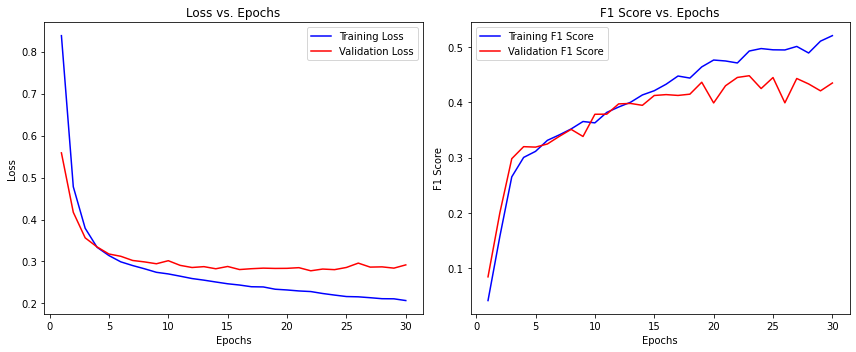

In [20]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='RNN').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())


train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_rnn_word2vec.pth')


In [24]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='RNN').to(device)

model.load_state_dict(torch.load('./tk1_rnn_word2vec.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test F1 Score: 0.4928
Test Accuracy: 0.9159


* LSTM

Epoch 1/30 - Train Loss: 0.9511, Train F1: 0.0277, Val Loss: 0.6120, Val F1: 0.0408
Epoch 2/30 - Train Loss: 0.5402, Train F1: 0.0787, Val Loss: 0.4845, Val F1: 0.1427
Epoch 3/30 - Train Loss: 0.4358, Train F1: 0.1772, Val Loss: 0.4086, Val F1: 0.2033
Epoch 4/30 - Train Loss: 0.3790, Train F1: 0.2305, Val Loss: 0.3680, Val F1: 0.2522
Epoch 5/30 - Train Loss: 0.3453, Train F1: 0.2722, Val Loss: 0.3425, Val F1: 0.2870
Epoch 6/30 - Train Loss: 0.3231, Train F1: 0.2992, Val Loss: 0.3303, Val F1: 0.3193
Epoch 7/30 - Train Loss: 0.3068, Train F1: 0.3204, Val Loss: 0.3180, Val F1: 0.3156
Epoch 8/30 - Train Loss: 0.2943, Train F1: 0.3330, Val Loss: 0.3163, Val F1: 0.3339
Epoch 9/30 - Train Loss: 0.2844, Train F1: 0.3383, Val Loss: 0.3022, Val F1: 0.3404
Epoch 10/30 - Train Loss: 0.2761, Train F1: 0.3484, Val Loss: 0.2972, Val F1: 0.3388
Epoch 11/30 - Train Loss: 0.2679, Train F1: 0.3605, Val Loss: 0.2976, Val F1: 0.3400
Epoch 12/30 - Train Loss: 0.2610, Train F1: 0.3723, Val Loss: 0.2889, Val 

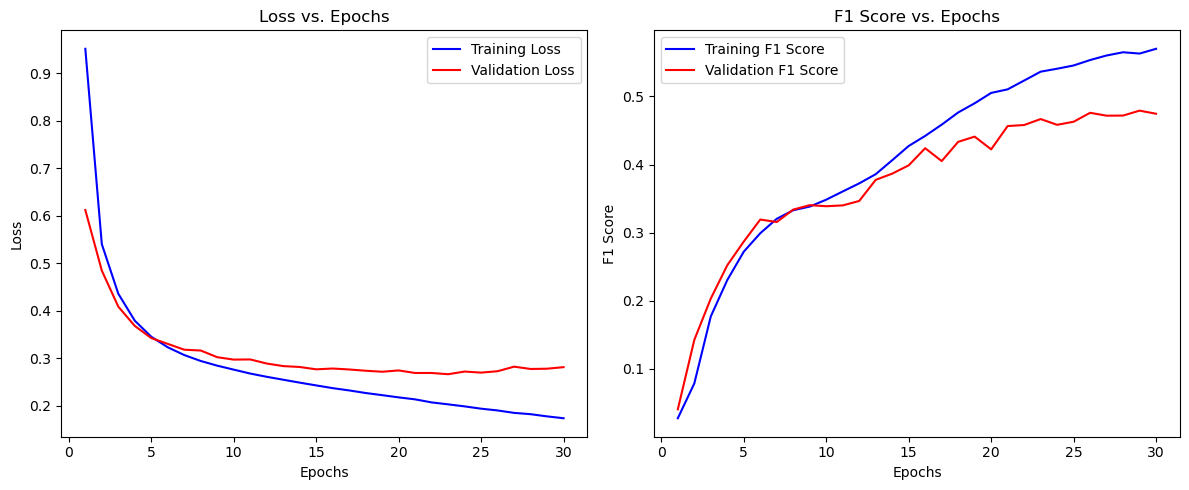

In [52]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='LSTM').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_lstm_word2vec.pth')

In [53]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='LSTM').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_lstm_word2vec.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())


test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test F1 Score: 0.5538
Test Accuracy: 0.9183


* GRU

Epoch 1/30 - Train Loss: 0.8554, Train F1: 0.0472, Val Loss: 0.5486, Val F1: 0.1094
Epoch 2/30 - Train Loss: 0.4699, Train F1: 0.1769, Val Loss: 0.4170, Val F1: 0.2326
Epoch 3/30 - Train Loss: 0.3749, Train F1: 0.2769, Val Loss: 0.3547, Val F1: 0.3023
Epoch 4/30 - Train Loss: 0.3302, Train F1: 0.3318, Val Loss: 0.3260, Val F1: 0.3284
Epoch 5/30 - Train Loss: 0.3041, Train F1: 0.3546, Val Loss: 0.3080, Val F1: 0.3601
Epoch 6/30 - Train Loss: 0.2859, Train F1: 0.3806, Val Loss: 0.2961, Val F1: 0.3718
Epoch 7/30 - Train Loss: 0.2728, Train F1: 0.3960, Val Loss: 0.2884, Val F1: 0.3835
Epoch 8/30 - Train Loss: 0.2604, Train F1: 0.4206, Val Loss: 0.2811, Val F1: 0.3961
Epoch 9/30 - Train Loss: 0.2507, Train F1: 0.4474, Val Loss: 0.2756, Val F1: 0.4149
Epoch 10/30 - Train Loss: 0.2427, Train F1: 0.4646, Val Loss: 0.2750, Val F1: 0.4234
Epoch 11/30 - Train Loss: 0.2345, Train F1: 0.4817, Val Loss: 0.2718, Val F1: 0.4301
Epoch 12/30 - Train Loss: 0.2281, Train F1: 0.5018, Val Loss: 0.2664, Val 

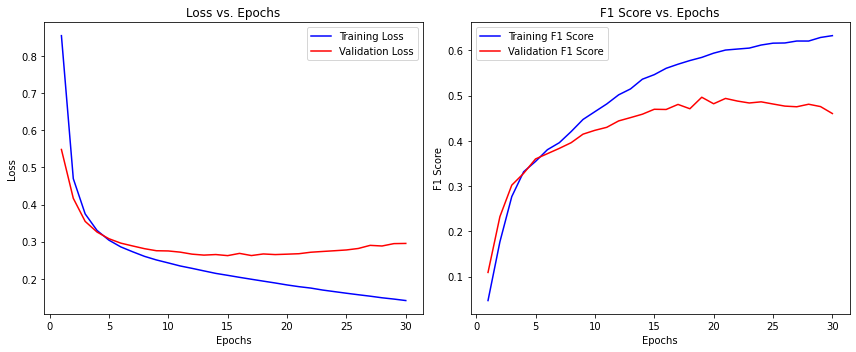

In [25]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='GRU').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_gru_word2vec.pth')

In [27]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='GRU').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_gru_word2vec.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test F1 Score: 0.5460
Test Accuracy: 0.9148


# GLOVE

In [15]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = file_path + '/glove.6B.300d.txt'
word2vec_output_file = file_path + '/glove.6B.300d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#glove = KeyedVectors.load_word2vec_format(file_path1 + '/glove.6B.300d.txt', no_header=True, binary=True)


/var/folders/_1/pytq1skj57b53vp2wq81373w0000gn/T/ipykernel_7344/2086610028.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [34]:
train_dataset = ReviewDataset(train_data, glove, 'glove')
val_dataset = ReviewDataset(val_data, glove, 'glove')
test_dataset = ReviewDataset(test_data, glove, 'glove')

In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

* Vanilla RNN

Epoch 1/30 - Train Loss: 0.8443, Train F1: 0.0299, Val Loss: 0.6143, Val F1: 0.0517
Epoch 2/30 - Train Loss: 0.5463, Train F1: 0.0932, Val Loss: 0.5000, Val F1: 0.1308
Epoch 3/30 - Train Loss: 0.4694, Train F1: 0.1613, Val Loss: 0.4564, Val F1: 0.1778
Epoch 4/30 - Train Loss: 0.4390, Train F1: 0.1808, Val Loss: 0.4384, Val F1: 0.1861
Epoch 5/30 - Train Loss: 0.4241, Train F1: 0.1867, Val Loss: 0.4330, Val F1: 0.1892
Epoch 6/30 - Train Loss: 0.4104, Train F1: 0.1931, Val Loss: 0.4331, Val F1: 0.1895
Epoch 7/30 - Train Loss: 0.4017, Train F1: 0.2025, Val Loss: 0.4159, Val F1: 0.2117
Epoch 8/30 - Train Loss: 0.3951, Train F1: 0.2145, Val Loss: 0.4112, Val F1: 0.2353
Epoch 9/30 - Train Loss: 0.3876, Train F1: 0.2315, Val Loss: 0.4087, Val F1: 0.2179
Epoch 10/30 - Train Loss: 0.3817, Train F1: 0.2477, Val Loss: 0.3974, Val F1: 0.2551
Epoch 11/30 - Train Loss: 0.3750, Train F1: 0.2549, Val Loss: 0.3959, Val F1: 0.2626
Epoch 12/30 - Train Loss: 0.3706, Train F1: 0.2642, Val Loss: 0.3927, Val 

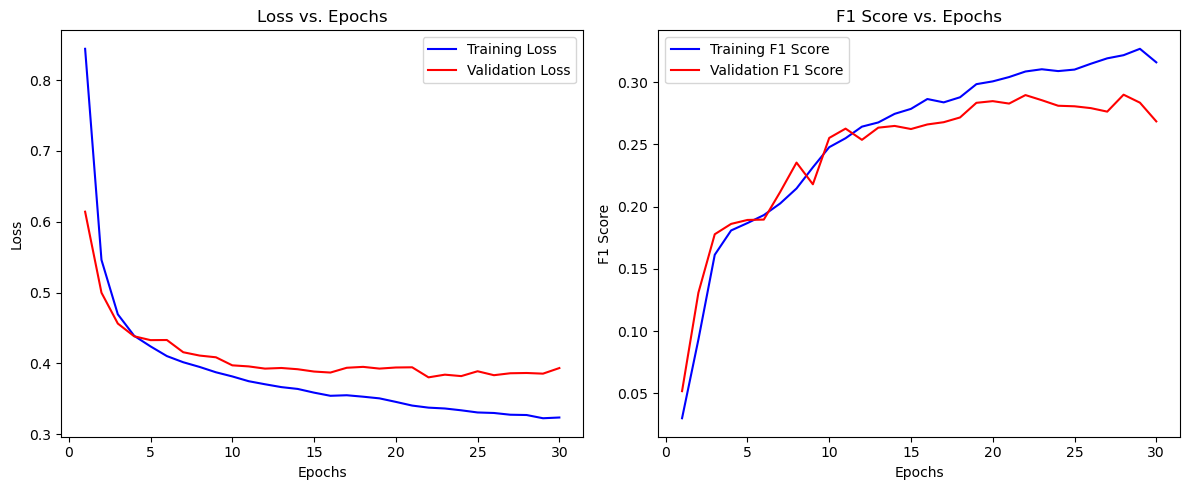

In [27]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='RNN').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_rnn_glove.pth')


In [28]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='RNN').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_rnn_glove.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test F1 Score: 0.3170
Test Accuracy: 0.8898


* LSTM

Epoch 1/30 - Train Loss: 0.9406, Train F1: 0.0271, Val Loss: 0.6805, Val F1: 0.0392
Epoch 2/30 - Train Loss: 0.6148, Train F1: 0.0441, Val Loss: 0.5658, Val F1: 0.0605
Epoch 3/30 - Train Loss: 0.5210, Train F1: 0.1199, Val Loss: 0.4938, Val F1: 0.1597
Epoch 4/30 - Train Loss: 0.4623, Train F1: 0.1657, Val Loss: 0.4520, Val F1: 0.1776
Epoch 5/30 - Train Loss: 0.4293, Train F1: 0.1740, Val Loss: 0.4296, Val F1: 0.1887
Epoch 6/30 - Train Loss: 0.4087, Train F1: 0.1896, Val Loss: 0.4158, Val F1: 0.1911
Epoch 7/30 - Train Loss: 0.3946, Train F1: 0.2018, Val Loss: 0.4148, Val F1: 0.1932
Epoch 8/30 - Train Loss: 0.3825, Train F1: 0.2182, Val Loss: 0.4033, Val F1: 0.2288
Epoch 9/30 - Train Loss: 0.3731, Train F1: 0.2347, Val Loss: 0.4027, Val F1: 0.2372
Epoch 10/30 - Train Loss: 0.3657, Train F1: 0.2480, Val Loss: 0.3941, Val F1: 0.2488
Epoch 11/30 - Train Loss: 0.3574, Train F1: 0.2640, Val Loss: 0.3960, Val F1: 0.2512
Epoch 12/30 - Train Loss: 0.3509, Train F1: 0.2678, Val Loss: 0.3881, Val 

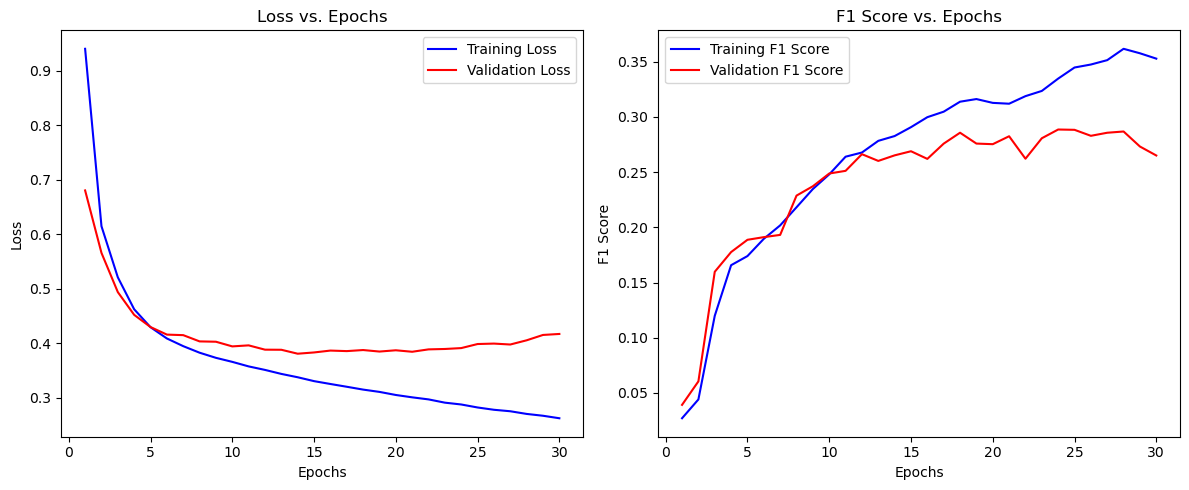

In [29]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='LSTM').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_lstm_glove.pth')


In [30]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='LSTM').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_lstm_glove.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test F1 Score: 0.3368
Test Accuracy: 0.8861


* GRU

Epoch 1/30 - Train Loss: 0.8999, Train F1: 0.0372, Val Loss: 0.6617, Val F1: 0.0581
Epoch 2/30 - Train Loss: 0.5865, Train F1: 0.0787, Val Loss: 0.5287, Val F1: 0.1283
Epoch 3/30 - Train Loss: 0.4815, Train F1: 0.1540, Val Loss: 0.4602, Val F1: 0.1676
Epoch 4/30 - Train Loss: 0.4278, Train F1: 0.1904, Val Loss: 0.4272, Val F1: 0.1902
Epoch 5/30 - Train Loss: 0.4014, Train F1: 0.2092, Val Loss: 0.4089, Val F1: 0.2044
Epoch 6/30 - Train Loss: 0.3868, Train F1: 0.2259, Val Loss: 0.3971, Val F1: 0.2323
Epoch 7/30 - Train Loss: 0.3749, Train F1: 0.2484, Val Loss: 0.3910, Val F1: 0.2425
Epoch 8/30 - Train Loss: 0.3647, Train F1: 0.2653, Val Loss: 0.3868, Val F1: 0.2567
Epoch 9/30 - Train Loss: 0.3564, Train F1: 0.2798, Val Loss: 0.3861, Val F1: 0.2682
Epoch 10/30 - Train Loss: 0.3489, Train F1: 0.2884, Val Loss: 0.3792, Val F1: 0.2758
Epoch 11/30 - Train Loss: 0.3403, Train F1: 0.3010, Val Loss: 0.3791, Val F1: 0.2820
Epoch 12/30 - Train Loss: 0.3343, Train F1: 0.3120, Val Loss: 0.3784, Val 

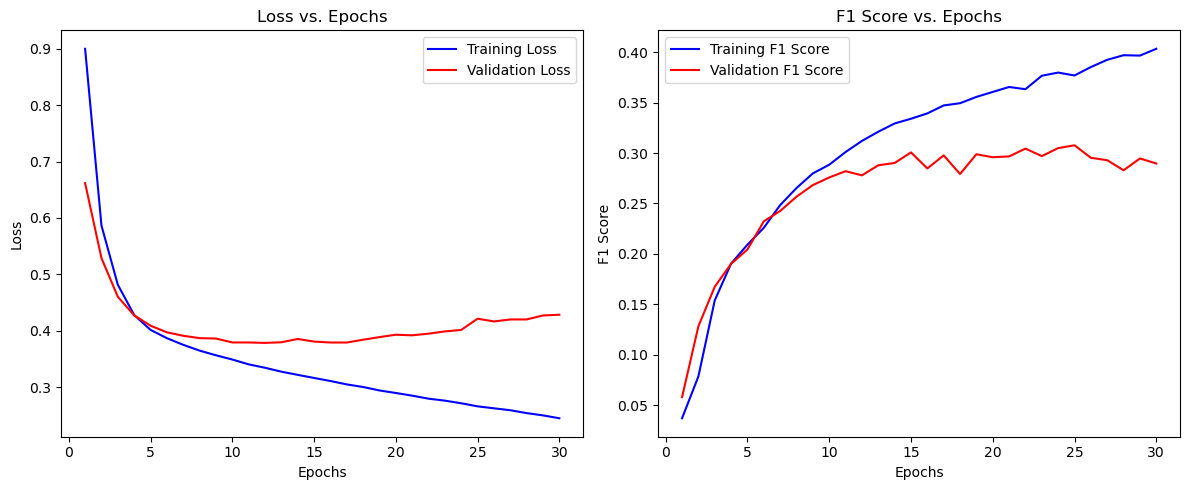

In [31]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='GRU').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_gru_glove.pth')


In [32]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='GRU').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_gru_glove.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test F1 Score: 0.3356
Test Accuracy: 0.8870


# FastText

In [38]:
from gensim.models.fasttext import FastText as FT_gensim

fasttext = FT_gensim.load_fasttext_format(file_path +'/cc.en.300.bin')

train_dataset = ReviewDataset(train_data, fasttext, 'fasttext')
val_dataset = ReviewDataset(val_data, fasttext, 'fasttext')
test_dataset = ReviewDataset(test_data, fasttext, 'fasttext')

/var/folders/_1/pytq1skj57b53vp2wq81373w0000gn/T/ipykernel_7344/3099300680.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext = FT_gensim.load_fasttext_format(file_path1 +'/cc.en.300.bin')


In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

* Vanilla RNN

Epoch 1/30 - Train Loss: 0.8735, Train F1: 0.0338, Val Loss: 0.5953, Val F1: 0.0427
Epoch 2/30 - Train Loss: 0.5029, Train F1: 0.1057, Val Loss: 0.4317, Val F1: 0.1823
Epoch 3/30 - Train Loss: 0.3822, Train F1: 0.2512, Val Loss: 0.3635, Val F1: 0.2681
Epoch 4/30 - Train Loss: 0.3281, Train F1: 0.3141, Val Loss: 0.3175, Val F1: 0.3386
Epoch 5/30 - Train Loss: 0.2989, Train F1: 0.3554, Val Loss: 0.2992, Val F1: 0.3559
Epoch 6/30 - Train Loss: 0.2795, Train F1: 0.3728, Val Loss: 0.2850, Val F1: 0.3672
Epoch 7/30 - Train Loss: 0.2669, Train F1: 0.3884, Val Loss: 0.2796, Val F1: 0.3781
Epoch 8/30 - Train Loss: 0.2578, Train F1: 0.3977, Val Loss: 0.2739, Val F1: 0.3918
Epoch 9/30 - Train Loss: 0.2500, Train F1: 0.4074, Val Loss: 0.2647, Val F1: 0.4093
Epoch 10/30 - Train Loss: 0.2438, Train F1: 0.4194, Val Loss: 0.2640, Val F1: 0.4322
Epoch 11/30 - Train Loss: 0.2373, Train F1: 0.4348, Val Loss: 0.2625, Val F1: 0.4383
Epoch 12/30 - Train Loss: 0.2339, Train F1: 0.4489, Val Loss: 0.2559, Val 

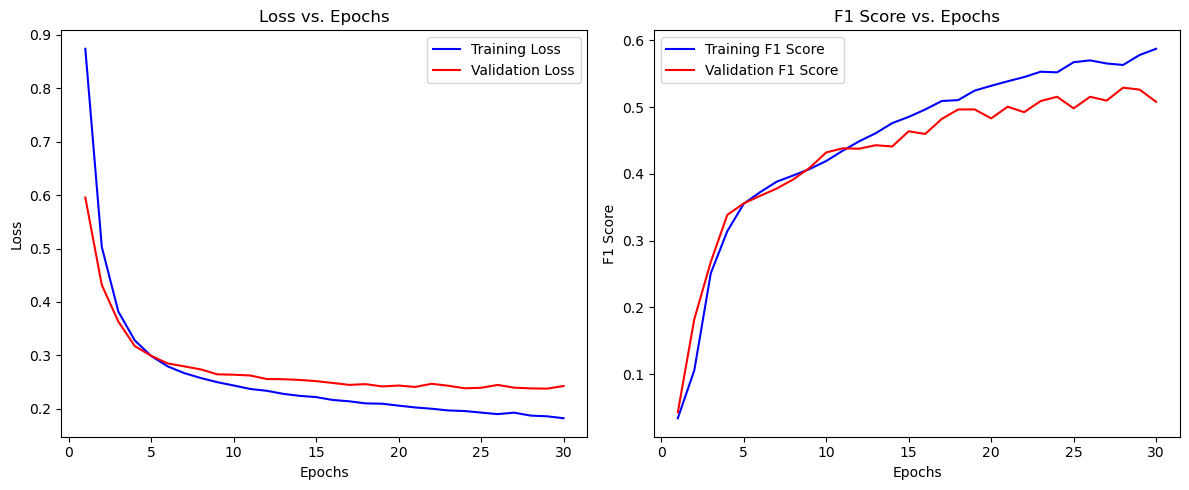

In [40]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='RNN').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval() 
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_rnn_fasttext.pth')


In [41]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='RNN').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_rnn_fasttext.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test F1 Score: 0.5369
Test Accuracy: 0.9295


* LSTM

Epoch 1/30 - Train Loss: 0.9613, Train F1: 0.0311, Val Loss: 0.6339, Val F1: 0.0426
Epoch 2/30 - Train Loss: 0.5660, Train F1: 0.0452, Val Loss: 0.5111, Val F1: 0.0538
Epoch 3/30 - Train Loss: 0.4619, Train F1: 0.0963, Val Loss: 0.4293, Val F1: 0.1618
Epoch 4/30 - Train Loss: 0.3911, Train F1: 0.1953, Val Loss: 0.3713, Val F1: 0.2433
Epoch 5/30 - Train Loss: 0.3420, Train F1: 0.2830, Val Loss: 0.3343, Val F1: 0.2952
Epoch 6/30 - Train Loss: 0.3096, Train F1: 0.3340, Val Loss: 0.3079, Val F1: 0.3435
Epoch 7/30 - Train Loss: 0.2886, Train F1: 0.3615, Val Loss: 0.2943, Val F1: 0.3621
Epoch 8/30 - Train Loss: 0.2729, Train F1: 0.3776, Val Loss: 0.2799, Val F1: 0.3741
Epoch 9/30 - Train Loss: 0.2609, Train F1: 0.3882, Val Loss: 0.2701, Val F1: 0.3828
Epoch 10/30 - Train Loss: 0.2510, Train F1: 0.3981, Val Loss: 0.2682, Val F1: 0.3889
Epoch 11/30 - Train Loss: 0.2433, Train F1: 0.4089, Val Loss: 0.2600, Val F1: 0.4012
Epoch 12/30 - Train Loss: 0.2365, Train F1: 0.4160, Val Loss: 0.2555, Val 

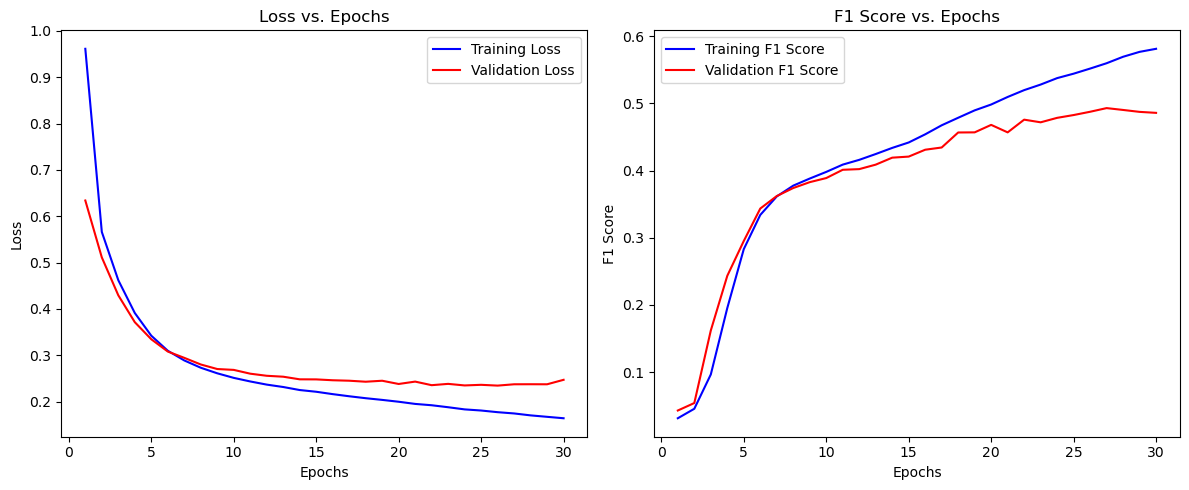

In [42]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='LSTM').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_lstm_fasttext.pth')


In [43]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='LSTM').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_lstm_fasttext.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test F1 Score: 0.4840
Test Accuracy: 0.9216


* GRU

Epoch 1/30 - Train Loss: 0.9090, Train F1: 0.0359, Val Loss: 0.5865, Val F1: 0.0438
Epoch 2/30 - Train Loss: 0.5044, Train F1: 0.1047, Val Loss: 0.4395, Val F1: 0.1587
Epoch 3/30 - Train Loss: 0.3868, Train F1: 0.2476, Val Loss: 0.3508, Val F1: 0.3082
Epoch 4/30 - Train Loss: 0.3200, Train F1: 0.3337, Val Loss: 0.3061, Val F1: 0.3484
Epoch 5/30 - Train Loss: 0.2842, Train F1: 0.3698, Val Loss: 0.2809, Val F1: 0.3845
Epoch 6/30 - Train Loss: 0.2637, Train F1: 0.3900, Val Loss: 0.2671, Val F1: 0.4002
Epoch 7/30 - Train Loss: 0.2487, Train F1: 0.4057, Val Loss: 0.2573, Val F1: 0.3975
Epoch 8/30 - Train Loss: 0.2376, Train F1: 0.4186, Val Loss: 0.2495, Val F1: 0.4137
Epoch 9/30 - Train Loss: 0.2287, Train F1: 0.4283, Val Loss: 0.2459, Val F1: 0.4127
Epoch 10/30 - Train Loss: 0.2207, Train F1: 0.4419, Val Loss: 0.2383, Val F1: 0.4300
Epoch 11/30 - Train Loss: 0.2130, Train F1: 0.4546, Val Loss: 0.2350, Val F1: 0.4396
Epoch 12/30 - Train Loss: 0.2066, Train F1: 0.4671, Val Loss: 0.2330, Val 

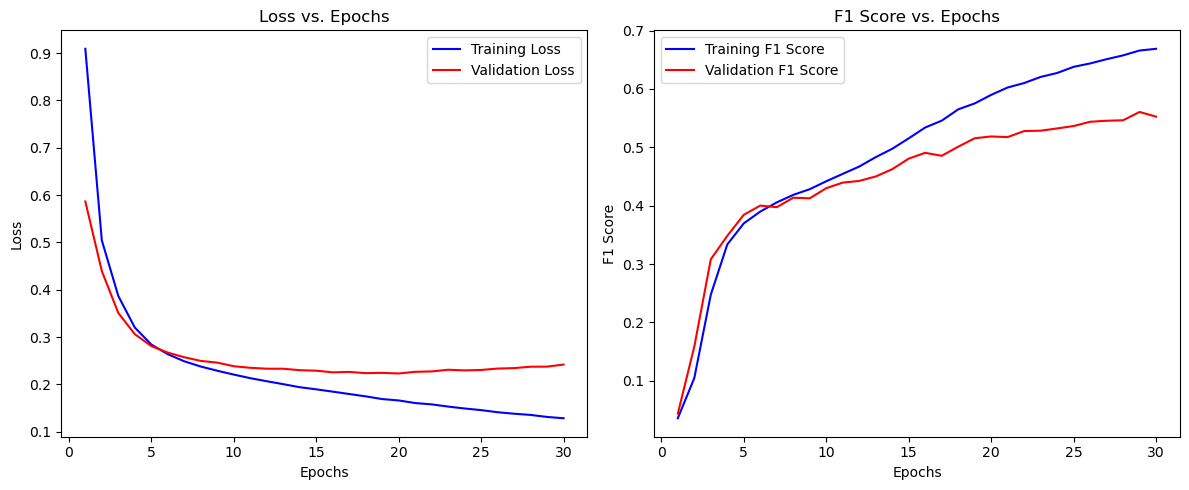

In [44]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='GRU').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters())

train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, train_losses, val_losses, train_f1_scores, val_f1_scores)

model.eval()  
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plot_loss_and_f1(train_losses, val_losses, train_f1_scores, val_f1_scores)
torch.save(model.state_dict(), file_path + '/tk1_gru_fasttext.pth')

In [45]:
model = BaseModel(input_size=300, hidden_size=64, output_size=27, model_type='GRU').to(device)

model.load_state_dict(torch.load(file_path+ '/tk1_gru_fasttext.pth'))

model.eval()
test_true_labels = []
test_pred_labels = []

with torch.no_grad():
    for vectors, labels in test_loader:
        vectors, labels = vectors.to(device), labels.to(device)
        outputs = model(vectors)
        _, predicted = torch.max(outputs, -1)
        test_true_labels.extend(labels.view(-1).cpu().numpy())
        test_pred_labels.extend(predicted.view(-1).cpu().numpy())

test_true_labels_np = np.array(test_true_labels)
test_pred_labels_np = np.array(test_pred_labels)

test_f1 = f1_score(test_true_labels_np[test_true_labels_np != -1], test_pred_labels_np[test_true_labels_np != -1], average='macro')
test_acc = compute_accuracy(test_true_labels_np, test_pred_labels_np)

print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test F1 Score: 0.5887
Test Accuracy: 0.9321
